In [1]:
# import the necessary libraries for the project!
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## <span style="color:brown">General modelling procedure applied to non-stationary datasets: Practice 1 (the dataset is a record of 500 days sales starting from Jan 2019): Forecast the last 50 timesteps</span>

In [2]:
#load the data into Jupyter notebook interface

df1 = pd.read_csv(r'C:\Users\HP\pyfold\data_ts\widget_sales.csv')
df1.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [3]:
df1.shape

(500, 1)

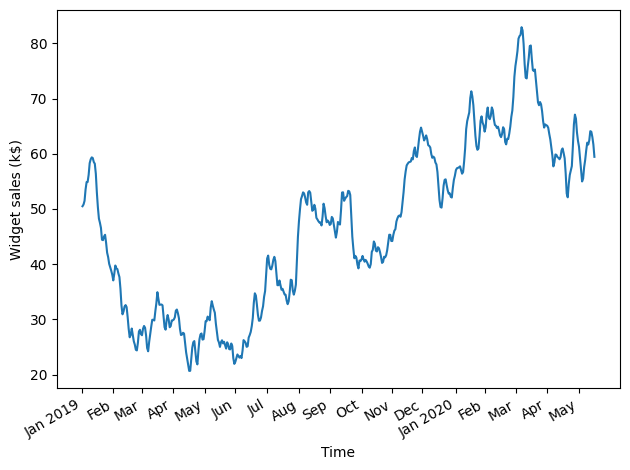

In [4]:
# let's plot the dataset for a quick visualisation

fig, ax = plt.subplots()

ax.plot(df1['widget_sales'])

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks([0, 30, 58, 88, 119, 149, 180, 211, 241, 272, 302, 331, 364, 392, 423, 453, 484],
           ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May']
)

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
# check for stationarity with the ADF test!

ADF_stat_res = adfuller(df1['widget_sales'])

print(ADF_stat_res[0])
print('.............')
print(ADF_stat_res[1])

-1.5121662069359063
.............
0.5274845352272597


p-value > 0.05, we cannot reject the null hypothesis stating there is a unit root, therefore the series is not stationary! it needs a differencing

In [6]:
# let's apply a one-order differencing and check the ADF again

diff_df1 =  np.diff(df1['widget_sales'], n=1)

ADF_stat_res = adfuller(diff_df1)

print(ADF_stat_res[0])
print('.............')
print(ADF_stat_res[1])

-10.576657780341957
.............
7.076922818587346e-19


the ADF statistic is a large negative number and p-value < 0.05, the series is now stationary and the parameter d will be set to 1

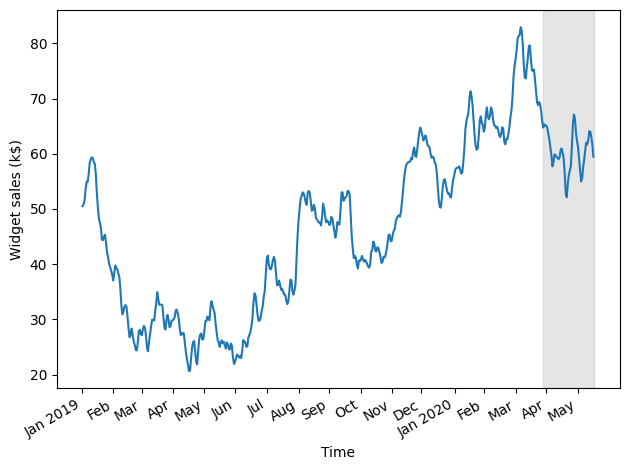

In [7]:
# let's plot the forecasted period

fig, ax = plt.subplots()

ax.plot(df1['widget_sales'])

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')
ax.axvspan(450, 500, color='#808080', alpha=0.2)

plt.xticks([0, 30, 58, 88, 119, 149, 180, 211, 241, 272, 302, 331, 364, 392, 423, 453, 484],
           ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May']
)

fig.autofmt_xdate()
plt.tight_layout()

we are goint to forecast the last 50 periods and check our predictions against the actual values

In [8]:
# let's split the dataset into train and test sets

train  = df1[:-50]
test = df1[-50:]

print(len(train), len(test))

450 50


In [9]:
# let's select the appropriate model based upon the AIC 

from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
# let's create a list of possible values of p and q

ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [11]:
# let's input the parameters of the optimize_ARMA function

result_df = optimize_ARMA(train, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",1251.435016
1,"(0, 2)",1254.409302
2,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
4,"(3, 0)",1255.967595
5,"(1, 2)",1255.982548
6,"(1, 1)",1256.284513
7,"(3, 1)",1256.850863
8,"(2, 2)",1256.918179
9,"(1, 3)",1257.643262


In [12]:
# let's fit the model based on the lowest AIC which is (3,3)

model_best = SARIMAX(train, order=(3,1,3), simple_differencing=False)

model = model_best.fit(disp=False)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:           widget_sales   No. Observations:                  450
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -618.718
Date:                Tue, 23 May 2023   AIC                           1251.435
Time:                        22:06:25   BIC                           1280.184
Sample:                             0   HQIC                          1262.767
                                - 450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3630      0.064     21.179      0.000       1.237       1.489
ar.L2         -1.3528      0.065    -20.833      0.000      -1.480      -1.226
ar.L3          0.3509      0.064      5.459      0.0

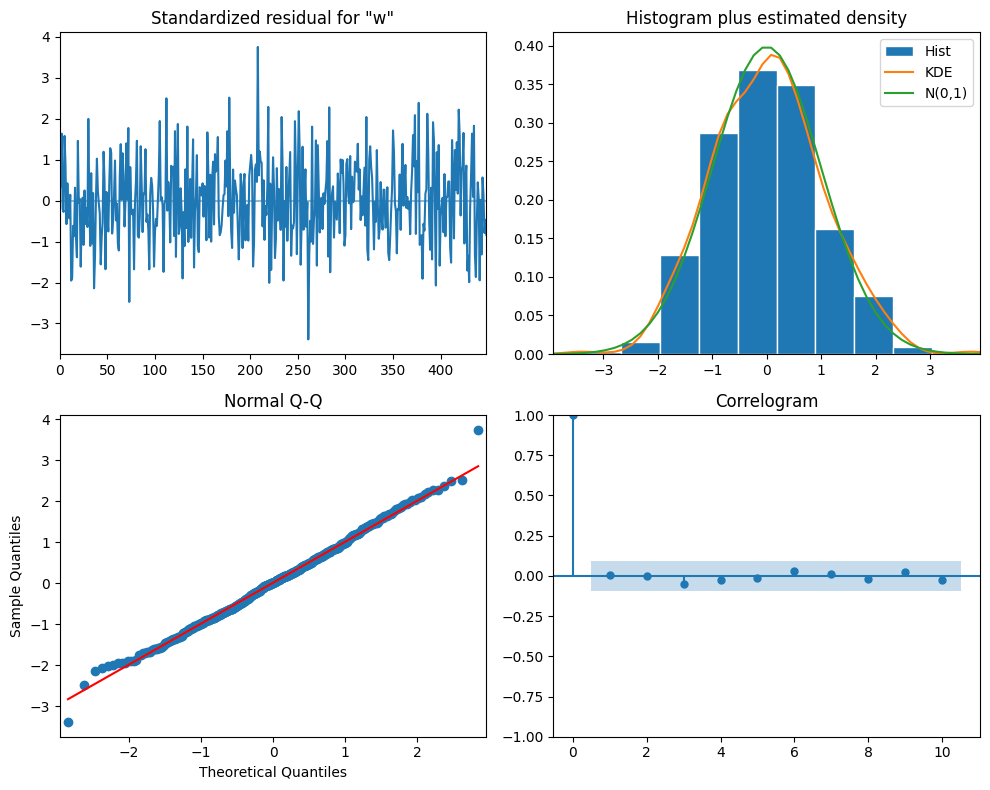

In [13]:
# let's analyse the residuals

model.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

the Q-Q plot shows something that is nearly a straight line very close to the line y=x, and the histogram shows a distribution  similar to that of a normal distribution. The correlograms depicts no autocorrelation except in lag 0!

In [14]:
# let's apply the Ljung Box statistic test

Residuals = model.resid

acorr_ljungbox(Residuals, lags=np.arange(1,11,1), return_df=True)

,lb_stat,lb_pvalue
1,0.017692,0.894184
2,0.045308,0.977601
3,0.241776,0.970579
4,0.263641,0.992039
5,0.284018,0.997933
6,0.704738,0.994388
7,0.828538,0.997142
8,0.903314,0.998789
9,0.953310,0.999538
10,1.003607,0.999825


All the p-values are greater than 0.05, so we can reject the null hypothesis here; therefore the residuals are independently distributed. In other words, there are uncorrelated

In [15]:
# let's define a function to perform the forecast 

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [16]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df1, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df1, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df1, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,widget_sales,pred_mean,pred_last_value,pred_ARIMA
450,64.736005,45.472231,65.906136,64.810974
451,65.316972,45.514944,64.736005,64.575202
452,65.172070,45.558754,65.316972,66.240570
453,65.075506,45.602050,65.172070,64.631571
454,64.703173,45.644943,65.075506,64.994452


In [17]:
# let's calculate the MSE 

mse_mean = mean_squared_error(test['widget_sales'], test['pred_mean'])
mse_last = mean_squared_error(test['widget_sales'], test['pred_last_value'])
mse_arima = mean_squared_error(test['widget_sales'], test['pred_ARIMA'])

print(mse_mean, mse_last, mse_arima)

214.2263297022068 2.544063859442141 1.1562523696517015


In [18]:
# let's calculate the MAE which is easier to interpret 

mae_mean = mean_absolute_error(test['widget_sales'], test['pred_mean'])
mae_last = mean_absolute_error(test['widget_sales'], test['pred_last_value'])
mae_arima = mean_absolute_error(test['widget_sales'], test['pred_ARIMA'])

print(mae_mean, mae_last, mae_arima)

14.205236749651792 1.294973353904902 0.8457761180462472


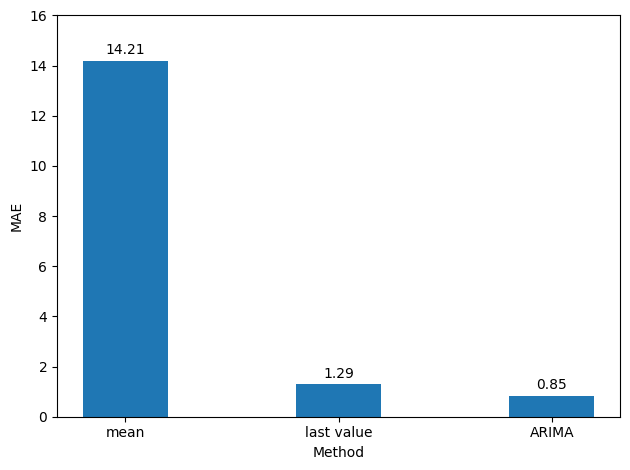

In [19]:
# let's represent the MAE

fig, ax = plt.subplots()

x = ['mean', 'last value', 'ARIMA']
y = [mae_mean, mae_last, mae_arima]

ax.bar(x, y, width = 0.4)
ax.set_xlabel('Method')
ax.set_ylabel('MAE')

ax.set_ylim(0,16)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

ARIMA outperforms the other baseline methods. As the MAE shows, the prediction are 1570 greater or smaller than the actual values. (the data is given is K$)

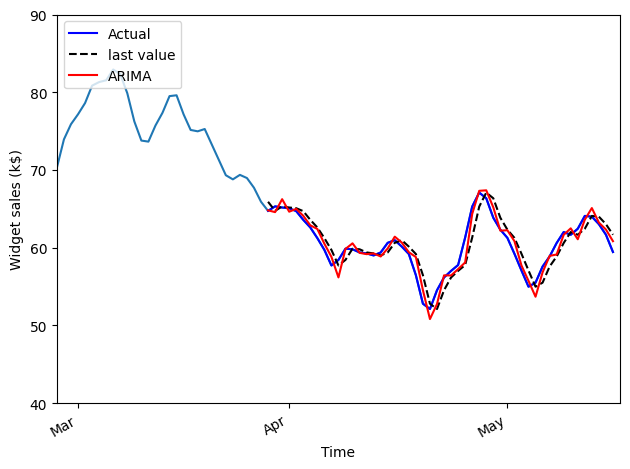

In [20]:
# let's plot the actual and the various predictions

fig, ax = plt.subplots()

ax.plot(df1['widget_sales'])
ax.plot(test['widget_sales'], 'b-', label='Actual')
ax.plot(test['pred_last_value'], 'k--', label = 'last value')
ax.plot(test['pred_ARIMA'], 'r-', label = 'ARIMA')
ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks([0, 30, 58, 88, 119, 149, 180, 211, 241, 272, 302, 331, 364, 392, 423, 453, 484],
           ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May']
)

ax.set_xlim(420, 500)
ax.set_ylim(40, 90)

fig.autofmt_xdate()
plt.tight_layout()

## <span style="color:darkblue">General modelling procedure applied to non-stationary datasets: Practice 2 (the dataset is a record of 1000 week foot traffic in a store from the year 2000): Forecast the last 52 weeks</span>

In [21]:
# import the necessary libraries for the project!
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [22]:
#load the data into Jupyter notebook interface

df2 = pd.read_csv(r'C:\Users\HP\pyfold\data_ts\foot_traffic.csv')
df2.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


In [23]:
df2.shape

(1000, 1)

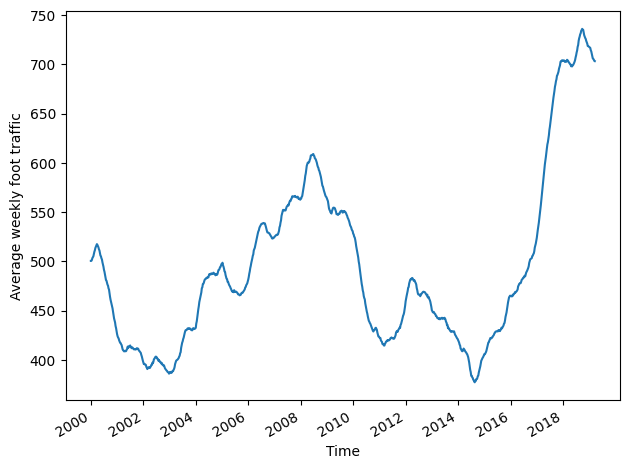

In [24]:
# let's plot the data for a first visualization

fig, ax = plt.subplots()

ax.plot(df2['foot_traffic'])

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [25]:
#check the stationarity with the ADF test

ADF_stat_res = adfuller(df2['foot_traffic'])

print(ADF_stat_res[0])
print('..............')
print(ADF_stat_res[1])

-1.1758885999240758
..............
0.6838808917896185


In [26]:
# let's perform a one order differencing and check the ADF test

diff_df2 = np.diff(df2['foot_traffic'])

ADF_stat_res = adfuller(diff_df2)

print(ADF_stat_res[0])
print('..............')
print(ADF_stat_res[1])

-5.268231347422051
..............
6.369317654781036e-06


the ADF statistic is a large negative number and p-value < 0.05, the series is now stationary and the parameter d will be set to 1

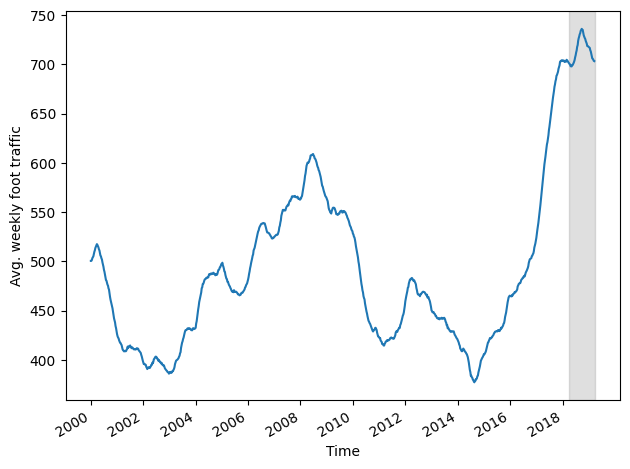

In [27]:
# let's plot the forecasted period

fig, ax = plt.subplots()

ax.plot(df2['foot_traffic'])

ax.set_xlabel('Time')
ax.set_ylabel('Avg. weekly foot traffic')
ax.axvspan(948, 1000, color= '#808080', alpha =.25  )

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [28]:
#let's split the dataset into train and test set

train = df2[:-52]
test = df2[-52:]

print(len(train), len(test))

948 52


In [29]:
# let's select the appropriate model based upon the AIC 

from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [30]:
# create the possible combination of p and q values

ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

list_order = list(product(ps, qs))

In [31]:
# let's input the parameters of the function optimze_ARMA

result_df = optimize_ARMA(train, list_order )
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 3)",2658.013441
1,"(3, 1)",2658.595081
2,"(3, 0)",2658.691777
3,"(2, 1)",2659.873751
4,"(3, 2)",2659.916852
5,"(2, 3)",2659.977855
6,"(3, 3)",2660.802093
7,"(2, 2)",2661.229924
8,"(2, 0)",2667.725827
9,"(1, 2)",2669.719835


In [32]:
# let's fit the model based on the lowest AIC and les complex which is (3,0)

best_model =  SARIMAX(train, order=(3,1,0), simple_differencing = False)

model = best_model.fit(disp=False)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:           foot_traffic   No. Observations:                  948
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1325.346
Date:                Tue, 23 May 2023   AIC                           2658.692
Time:                        22:09:22   BIC                           2678.105
Sample:                             0   HQIC                          2666.090
                                - 948                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3165      0.033      9.603      0.000       0.252       0.381
ar.L2          0.4802      0.031     15.510      0.000       0.419       0.541
ar.L3          0.1077      0.034      3.156      0.0

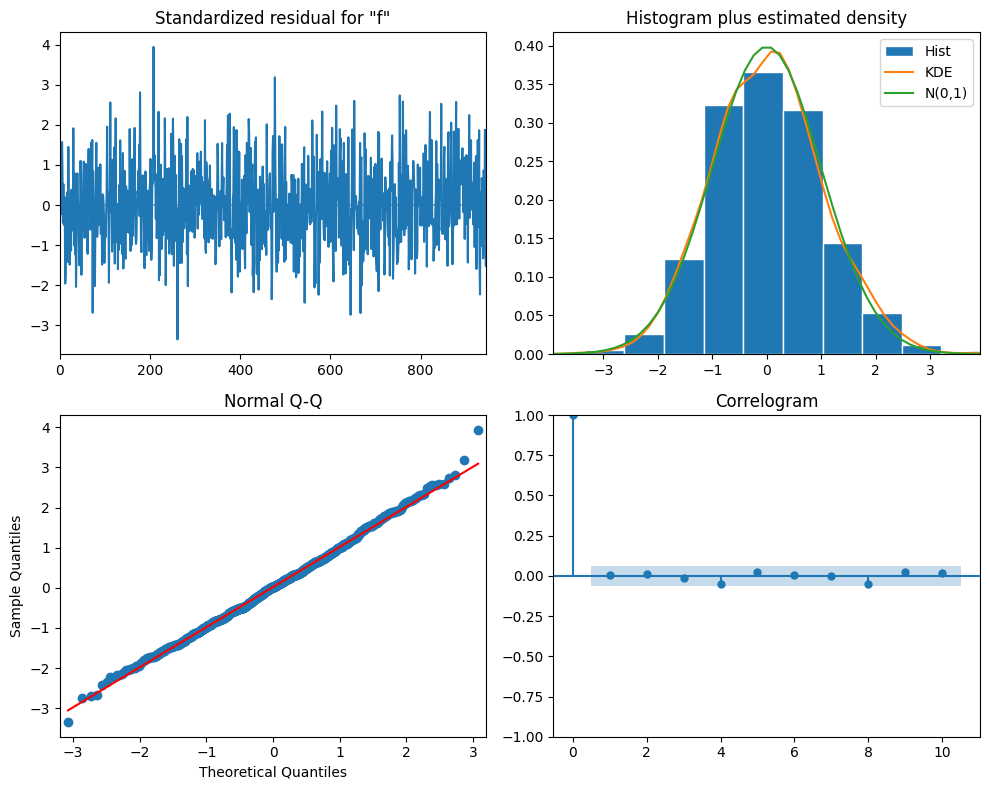

In [33]:
# let's analyse the residuals

model.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

the Q-Q plot shows a straight line whose equation is y=x, and the histogram shows a distribution similar to that of a normal distribution. The correlograms depicts no autocorrelation except in lag 0!

In [34]:
# let's perform the Ljung Box statistic test

Residuals = model.resid

acorr_ljungbox(Residuals, lags = np.arange(1,11,1), return_df =True)

,lb_stat,lb_pvalue
1,5.283576e-07,0.999420
2,2.953439e-03,0.998524
3,1.120838e-02,0.999685
4,1.156744e-02,0.999983
5,1.171482e-02,0.999999
6,2.057364e-02,1.000000
7,2.283018e-02,1.000000
8,2.393564e-02,1.000000
9,2.501986e-02,1.000000
10,2.585504e-02,1.000000


All the p-values are greater than 0.05, so we can reject the null hypothesis here; therefore the residuals are independently distributed. In other words, there are uncorrelated

In [35]:
# let's define a function to perform the forecast

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [36]:
#let's input the parameters of the function

Train_len = len(train)
Horizon = len(test)
Window = 1

pred_mean = rolling_forecast(df2, Train_len, Horizon, Window, 'mean')
pred_last = rolling_forecast(df2, Train_len, Horizon, Window, 'last')
pred_arima = rolling_forecast(df2, Train_len, Horizon, Window, 'ARIMA')

# let's add the predictions to the test set

test.loc[:, 'Mean'] = pred_mean
test.loc[:, 'Last'] = pred_last
test.loc[:, 'arima'] = pred_arima

test.head()

,foot_traffic,Mean,Last,arima
948,701.686830,481.204906,702.463430,701.743717
949,701.112198,481.437237,701.686830,700.872282
950,700.221501,481.668474,701.112198,700.447460
951,699.937948,481.898288,700.221501,699.580032
952,698.107264,482.127321,699.937948,699.358669


In [37]:
# let's compute the MSE

mse_mean = mean_squared_error(test['foot_traffic'], test['Mean'])
mse_last = mean_squared_error(test['foot_traffic'], test['Last'])
mse_arima = mean_squared_error(test['foot_traffic'], test['arima'])

print(mse_mean, mse_last, mse_arima)

52086.252587374445 3.0680952615237675 0.9242486965166763


In [38]:
# let's calculate the MAE
mae_mean = mean_absolute_error(test['foot_traffic'], test['Mean'])
mae_last = mean_absolute_error(test['foot_traffic'], test['Last'])
mae_arima = mean_absolute_error(test['foot_traffic'], test['arima'])

print(mae_mean, mae_last, mae_arima)

227.9348827539398 1.4751845139589823 0.7524470196141806


We can clearly notice the the ARIMA (3, 1, 0) outperforms the others. In addition, the predictions are 0.75 weeks greater or smaller than the actual predictions

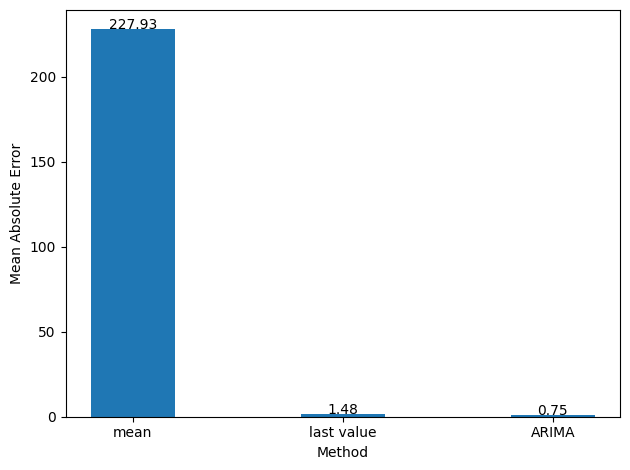

In [39]:
#let's plot the MAE

fig, ax = plt.subplots()

x = ['mean', 'last value', 'ARIMA']
y = [mae_mean, mae_last, mae_arima]

ax.bar(x, y, width= 0.4)
ax.set_xlabel('Method')
ax.set_ylabel('Mean Absolute Error')



for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()


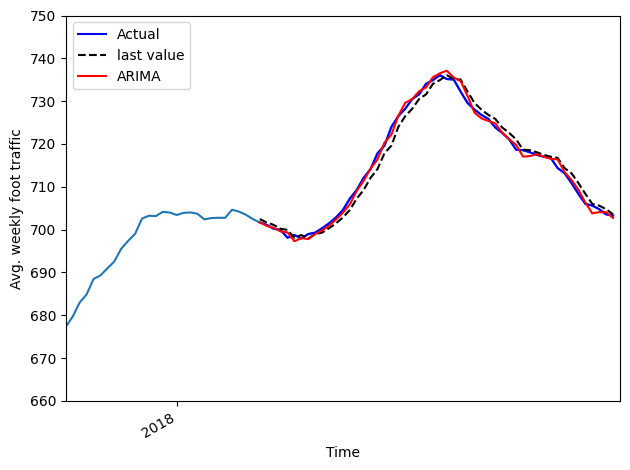

In [40]:
# let's plot the actual and forecasted values

fig, ax = plt.subplots()
ax.plot(df2['foot_traffic'])
ax.plot(test['foot_traffic'], 'b-', label='Actual')
ax.plot(test['Last'], 'k--', label='last value' )
ax.plot(test['arima'], 'r-', label='ARIMA' )

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Avg. weekly foot traffic')


plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

ax.set_xlim(920, 1000)
ax.set_ylim(660, 750)

fig.autofmt_xdate()
plt.tight_layout()

In [41]:
# import the necessary libraries for the project!
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## <span style="color:blue">General modelling procedure applied to non-stationary datasets: Practice 3 (the dataset is a record of 10000 hours of  bandwidth starting from Jan 2019): Forecast the last 168 hours</span>

In [42]:
df3 = pd.read_csv(r'C:\Users\HP\pyfold\data_ts\bandwidth.csv')
df3.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


In [43]:
df3.shape

(10000, 1)

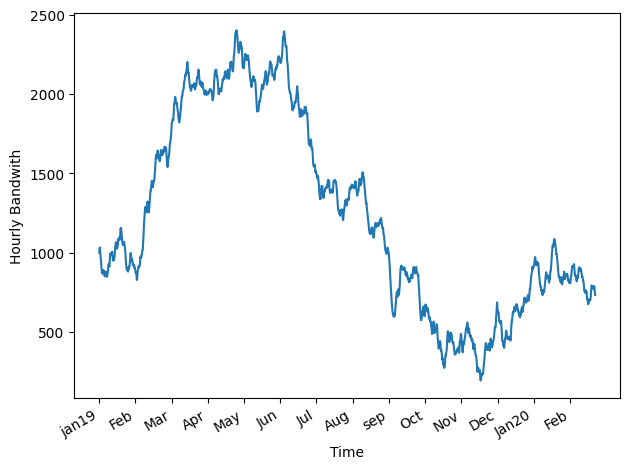

In [44]:
# let's plot the series for a quick visualization

fig, ax = plt.subplots()

ax.plot(df3['hourly_bandwidth'])

ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwith')

plt.xticks(np.arange(0, 10000, 730),
          ['jan19', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'sep',
          'Oct', 'Nov', 'Dec', 'Jan20', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [45]:
#let's check the stationarity with the ADF test

ADF_stat_res = adfuller(df3['hourly_bandwidth'])

print(ADF_stat_res[0])
print('............')
print(ADF_stat_res[1])

-0.871465319945207
............
0.7972240255014762


In [46]:
# let's perform a one order differencing and check the ADF test again

diff_df3 = np.diff(df3['hourly_bandwidth'])

ADF_stat_res = adfuller(diff_df3)

print(ADF_stat_res[0])
print('............')
print(ADF_stat_res[1])

-20.69485386378903
............
0.0


the ADF statistic is a large negative number and p-value < 0.05, the series is now stationary and the parameter d will be set to 1

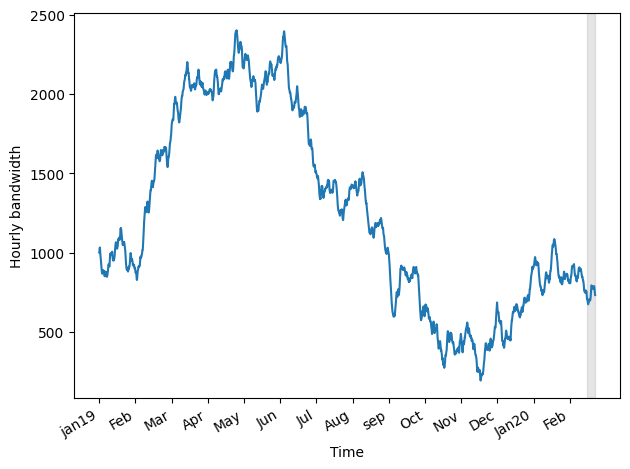

In [47]:
# let's plot the forecasted period

fig, ax = plt.subplots()

ax.plot(df3['hourly_bandwidth'])

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth')
ax.axvspan(9832, 10000, color='#808080', alpha=.2)

plt.xticks(np.arange(0, 10000, 730),
          ['jan19', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'sep',
          'Oct', 'Nov', 'Dec', 'Jan20', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [48]:
# let's split the data into train and test set

train = df3[:-168]
test = df3[-168:]

print(len(train), len(test))

9832 168


In [49]:
# let's select the appropriate model based upon the AIC 

from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [50]:
# let's create possible combination values for p and q

ps = range(0, 4, 1)
qs = range(0, 4, 1)
d=1

list_order = list(product(ps, qs))

In [51]:
# let's feed the function optimize_ARMA with its parameters

result_df = optimize_ARMA(train, list_order)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063157
1,"(2, 3)",27991.286794
2,"(2, 2)",27991.602936
3,"(3, 3)",27993.416226
4,"(1, 3)",28003.348864
5,"(1, 2)",28051.350913
6,"(3, 1)",28071.155049
7,"(3, 0)",28095.617602
8,"(2, 1)",28097.250206
9,"(2, 0)",28098.407146


In [52]:
# let's fit the model with the lowest AIC and the least complex model which is (2,2)

best_model = SARIMAX(train, order=(2, 1, 2), simple_differencing = False)

model = best_model.fit(disp=False)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:       hourly_bandwidth   No. Observations:                 9832
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -13990.801
Date:                Tue, 23 May 2023   AIC                          27991.603
Time:                        22:10:08   BIC                          28027.569
Sample:                             0   HQIC                         28003.788
                               - 9832                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

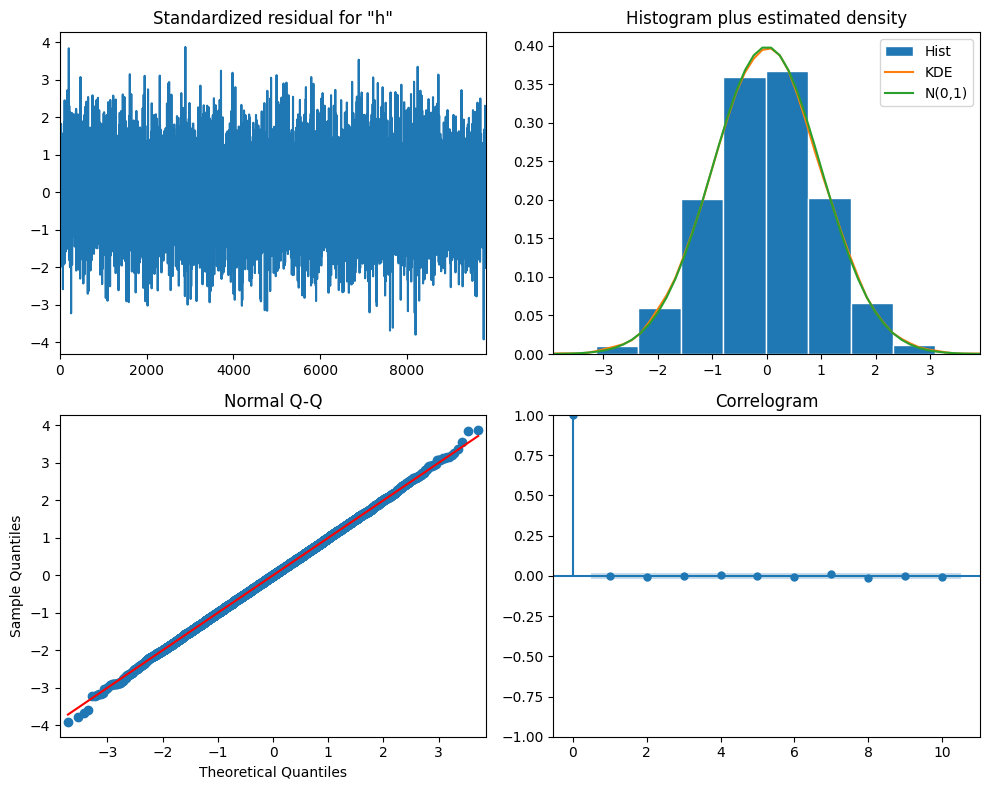

In [53]:
# let's analyse the residuals

model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()

the Q-Q plot shows a straight line whose equation is y=x, and the histogram shows a distribution similar to that of a normal distribution. The correlograms depicts no autocorrelation except in lag 0!

In [54]:
# let's apply the Ljung Box statistic test

Residuals = model.resid

acorr_ljungbox(Residuals, lags=np.arange(1,11,1), return_df=True)

,lb_stat,lb_pvalue
1,0.001923,0.965020
2,0.005134,0.997436
3,0.025881,0.998901
4,0.025943,0.999917
5,0.026603,0.999994
6,0.049674,0.999997
7,0.057616,1.000000
8,0.060490,1.000000
9,0.063568,1.000000
10,0.065937,1.000000


All the p-values are greater than 0.05, so we can reject the null hypothesis here; therefore the residuals are independently distributed. In other words, there are uncorrelated

In [55]:
#let's build a function to perform the forecast for the last 168 hours

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,1,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [56]:
#let's input the parameters of the function

Train_len = len(train)
Horizon = len(test)
Window = 1

pred_mean = rolling_forecast(df3, Train_len, Horizon, Window, 'mean')
pred_last = rolling_forecast(df3, Train_len, Horizon, Window, 'last')
pred_arima = rolling_forecast(df3, Train_len, Horizon, Window, 'ARIMA')

# let's add the predictions to the test set

test.loc[:, 'Mean'] = pred_mean
test.loc[:, 'Last'] = pred_last
test.loc[:, 'arima'] = pred_arima

test.head()

,hourly_bandwidth,Mean,Last,arima
9832,717.176939,1241.072644,723.120934,717.660272
9833,711.311745,1241.019364,717.176939,711.698712
9834,708.114679,1240.965500,711.311745,705.975840
9835,707.024482,1240.911321,708.114679,705.963069
9836,707.689774,1240.857042,707.024482,706.648886


In [57]:
# let's compute the MSE

mse_mean = mean_squared_error(test['hourly_bandwidth'], test['Mean'])
mse_last = mean_squared_error(test['hourly_bandwidth'], test['Last'])
mse_arima = mean_squared_error(test['hourly_bandwidth'], test['arima'])

print(mse_mean, mse_last, mse_arima)

249682.48538603788 6.301585933788195 0.9004296691665156


In [58]:
# let's calculate the MAE
mae_mean = mean_absolute_error(test['hourly_bandwidth'], test['Mean'])
mae_last = mean_absolute_error(test['hourly_bandwidth'], test['Last'])
mae_arima = mean_absolute_error(test['hourly_bandwidth'], test['arima'])

print(mae_mean, mae_last, mae_arima)

497.90230225600646 1.934101901850418 0.7839482210934466


ARIMA once again performs better than the other methods

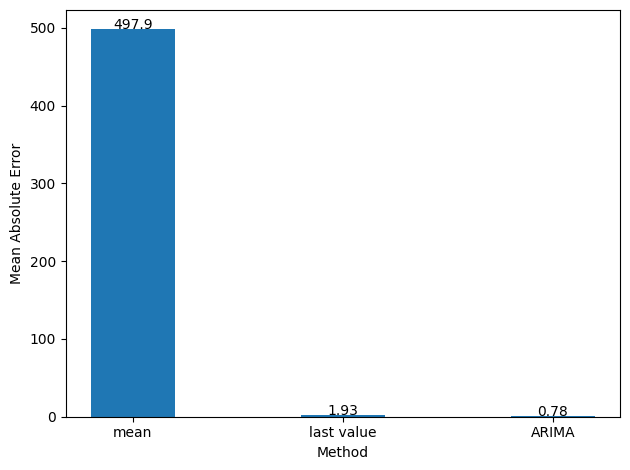

In [59]:
fig, ax = plt.subplots()

x = ['mean', 'last value', 'ARIMA']
y = [mae_mean, mae_last, mae_arima]

ax.bar(x, y, width= 0.4)
ax.set_xlabel('Method')
ax.set_ylabel('Mean Absolute Error')



for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()


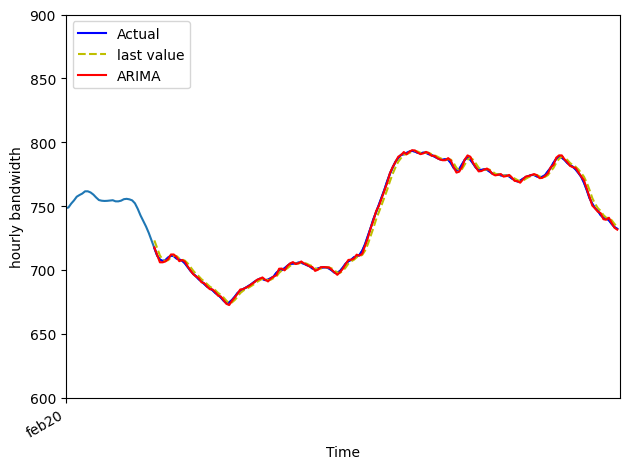

In [60]:
# let's plot the actual and forecasted values

fig, ax = plt.subplots()
ax.plot(df3['hourly_bandwidth'])
ax.plot(test['hourly_bandwidth'], 'b-', label='Actual')
ax.plot(test['Last'], 'y--', label='last value' )
ax.plot(test['arima'], 'r-', label='ARIMA' )

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('hourly bandwidth')


plt.xticks([9800, 1000], ['feb20', 'feb20'])


ax.set_xlim(9800, 10000)
ax.set_ylim(600, 900)

fig.autofmt_xdate()
plt.tight_layout()